# Random Forest Classification (RFC) - vegetation 
* SACFOR and Reflectance
* aided by: 
https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

In [29]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import sample
from rasterio.warp import reproject, Resampling
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.warp import transform
from rasterio.features import geometry_mask
from pyproj import CRS

from skimage import exposure
from shapely.geometry import box
from shapely.geometry import mapping

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

import contextily as ctx

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

### Datasets

In [424]:
# load the sacfor training data shape file
sacfor = gpd.read_file('/Volumes/Mere/UMB/Sidescan_surveys/gooseberries_sacfor_raster_samples/gooseberries_sacfor_raster_samples_corr.shp')
sacfor['SACFOR_veg'] = sacfor['SACFOR_veg'].replace('s', 'S')


# bathymetry tif file
bathy_file = '/Volumes/Mere/UMB/Sidescan_surveys/SALEM_Raster/Gooseberry_Bathy.tif'

# hyperspectral tif file
img_file = '/Volumes/Mere/UMB/rs_imagery_processing/PRISMA/20220629/L1A_L2B_L2C/geotiff_L2B_R/PRS_L2B_STD_20220629153618_20220629153623_0001_HCO_VNIR.tif'



### Change crs of sacfor to match PRISMA crs

In [261]:
# Load the hyperspectral data 
with rio.open(img_file) as src:
    img_crs = src.crs
sacfor = sacfor.to_crs(img_crs)

### Reproject Bathymetry file to match PRISMA

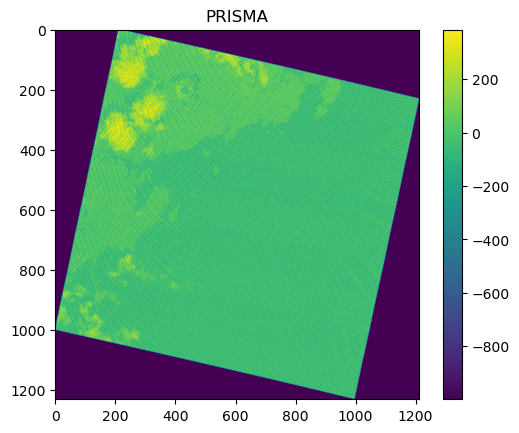

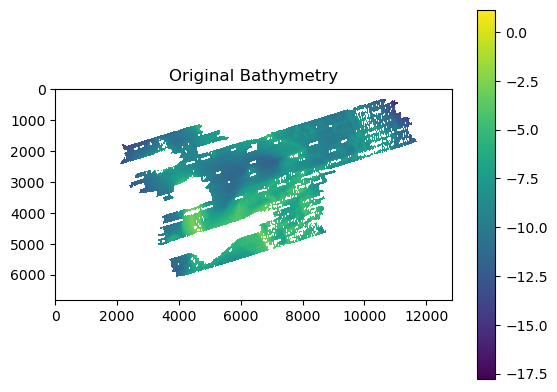

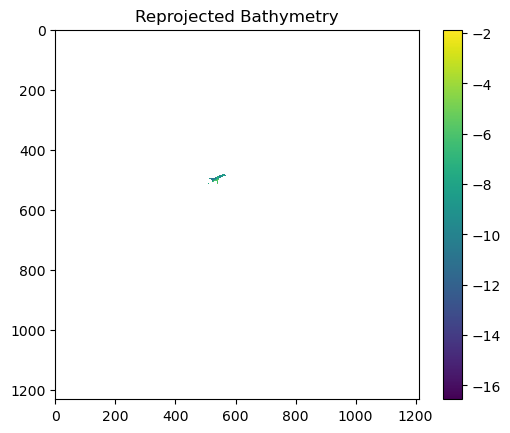

In [10]:
out_bathy_file = 'bathy_reprojected_prisma.tif'
# Load the hyperspectral data 
with rio.open(img_file) as src:
    arr = src.read()
    meta = src.meta

    plt.imshow(arr[38,:,:])
    plt.colorbar()
    plt.title('PRISMA')
    plt.show()
    
    # Load the bathymetry data 
    with rio.open(bathy_file) as bathy_src:
        bathy_arr = bathy_src.read(1)
        bathy_meta = bathy_src.meta

        bathy_arr[bathy_arr==-3.4028234663852886e+38] = np.nan
        plt.imshow(bathy_arr[:,:])
        plt.colorbar()
        plt.title('Original Bathymetry')
        plt.show()
        
        # Create a new raster file as the destination dataset
        dst_meta = meta.copy()
        dst_meta.update({
            'count': 1})
        

        with rio.open(out_bathy_file, 'w', **dst_meta) as dst:
            # Reproject the bathymetry raster to match the CRS of the hyperspectral data
            reproject(
                bathy_arr,
                destination=rio.band(dst, 1),
                src_crs=bathy_meta['crs'],
                dst_crs=meta['crs'],
                src_transform=bathy_meta['transform'],
                dst_transform=meta['transform'],
                resampling=Resampling.nearest)

# check reprojected bathymetry
with rio.open(out_bathy_file) as bathy_reproj:
    reproj_arr = bathy_reproj.read(1)
    reproj_arr[reproj_arr==-3.4028234663852886e+38] = np.nan
    reproj_arr[reproj_arr==-999] = np.nan
    plt.imshow(reproj_arr[:,:])
    plt.colorbar()
    plt.title('Reprojected Bathymetry')
    plt.show()  

### Crop PRISMA image to bathymetry area

In [15]:
#depth threshold 
z_thresh = -4

In [16]:
# get bounding box for cropping to site
# THIS IS WONKY BUT WORKS, NEED TO FIX


# Open the reprojected bathymetry file in read mode and read the data into bathy_arr
with rio.open(out_bathy_file) as reproj_bathy:
    bathy_arr = reproj_bathy.read(1)
    bathy_arr[bathy_arr==-999.0] = 0
    bathy_arr[bathy_arr==-3.4028234663852886e+38] = 0
    
    # get bounds of non-zero values
    # Determine the coordinates of where data exists
    non_zero_indices = bathy_arr.nonzero()

    # Calculate the minimum and maximum row and column indices of the data
    min_x, max_x = min(non_zero_indices[0]), max(non_zero_indices[0])
    min_y, max_y = min(non_zero_indices[1]), max(non_zero_indices[1])

    # Use the source raster's transform to convert pixel values to coordinate values
    min_x_coord, min_y_coord = src.xy(min_x, min_y)  # Coordinate for minimum values
    max_x_coord, max_y_coord = src.xy(max_x, max_y)  # Coordinate for maximum values
    
# Define the bounding box of the bathymetry data to crop rasters (xmin, ymin, xmax, ymax)
crop_bbox = [min_x_coord, max_y_coord, max_x_coord, min_y_coord]

/var/folders/69/6d1c0dr57w3c_dskwr2955mh0000gq/T/ipykernel_19264/840535158.py:73: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  depth = sacfor_bbox.plot(ax=ax2,


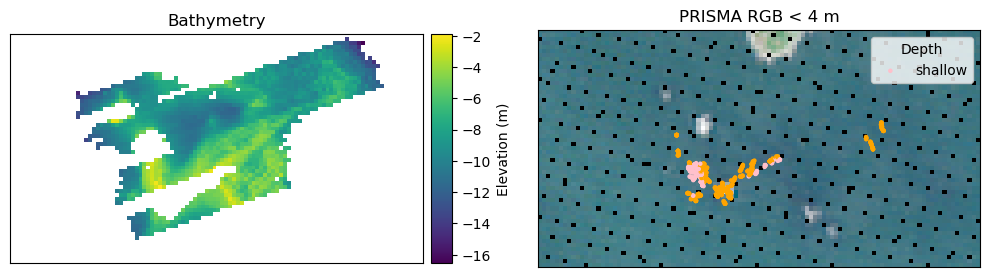

In [17]:

# Load the hyperspectral data 
with rio.open(img_file) as src:
    arr = src.read()
    
    meta = src.meta
    
    # Open the reprojected bathymetry file in read mode and read the data into bathy_arr
    with rio.open(out_bathy_file) as reproj_bathy:
        bathy_arr = reproj_bathy.read(1)

        bathy_arr[bathy_arr==-3.4028234663852886e+38] = np.nan

        # Crop rasters to bounding box
        window = rio.windows.from_bounds(*crop_bbox, transform=meta['transform'])
        arr_crop = src.read(window=window)
        bathy_arr_crop = reproj_bathy.read(window=window)[0]

        # mask out the NaN values to zero
        bathy_arr_crop[bathy_arr_crop == -3.4028234663852886e+38] = np.nan
        bathy_arr_crop[bathy_arr_crop == -999.0] = np.nan

        arr_crop[arr_crop == -999.0] = 0

        # Mask the hyperspectral array with the bathymetry array where the values are greater than -4
        mask = bathy_arr_crop < z_thresh
        arr_masked = np.ma.masked_array(arr_crop, mask=np.tile(mask, (arr_crop.shape[0], 1, 1)))

        # Filter sacfor points within the bounding box
        sacfor_bbox = sacfor[sacfor.within(box(*crop_bbox))]

        # Create a new column based on the elevations
        sacfor_bbox['depth criteria'] = np.where(sacfor_bbox['Elev(m)'] >= z_thresh, 'shallow', 'deep')

        # Add color criteria
        sacfor_bbox['color'] = np.where(sacfor_bbox['depth criteria'] == 'shallow', 'pink','orange')

        # sort out deep elevation
        sacfor_filt = sacfor[sacfor['Elev(m)']>=z_thresh]

        # ----- set up gamma corrected rgb for plotting
        corr_rgb = arr_crop[[32, 18, 8], :, :]

        # Apply contrast stretching to improve the visibility
        stretched = np.zeros_like(corr_rgb)
        
        for i in range(3):
            stretched[i] = exposure.rescale_intensity(corr_rgb[i])
        
        gamma_corrected = exposure.adjust_gamma(stretched, gamma=0.4)


        # plot the subset hyperspectral and bathymetry next to each other

        fig1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))
        
        im = ax1.imshow(bathy_arr_crop)
        ax1.set_title('Bathymetry')
        ax1.set_xticks([])
        ax1.set_yticks([])

        # colorbar
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad='2%')
        cbar = fig1.colorbar(im, cax=cax)
        cbar.set_label('Elevation (m)')

        # plot full rgb 
        show(gamma_corrected, transform = rio.windows.transform(window, src.transform), ax=ax2)
        ax2.set_title('PRISMA RGB < 4 m')

        # add dropcamera locations shallow/deep

        depth = sacfor_bbox.plot(ax=ax2, 
                         column='depth criteria', 
                         markersize=5,
                         legend=True, 
                         color = sacfor_bbox['color'])
        ax2.legend(["shallow" , "deep"], ncol = 1 , loc = "upper right", title = 'Depth')
        ax2.set_xticks([])
        ax2.set_yticks([])
        
        fig1.tight_layout()
        plt.show()



### Crop to Gooseberry Islands and mask deep water

In [18]:
#depth threshold 
z_thresh = -4

In [265]:
# get bounding box for cropping to site

# Define the original and target CRS
headwall_crs = CRS.from_epsg(26986)
target_crs = CRS.from_epsg(4326)

# Define the bounding box in the original CRS
headwall_crop_bbox = 258025, 919500, 258150, 919650

# Use rasterio to transform the bounding box coordinates
left, bottom, right, top = headwall_crop_bbox
transformed_left, transformed_bottom = rio.warp.transform(headwall_crs, target_crs, [left], [bottom])
transformed_right, transformed_top = rio.warp.transform(headwall_crs, target_crs, [right], [top])

# Create the new bounding box with the target CRS
gb_crop_bbox = [transformed_left[0], transformed_bottom[0], transformed_right[0], transformed_top[0]]

print(gb_crop_bbox)


[-70.7938004793205, 42.52388440265317, -70.7922640686694, 42.52522538849959]


/usr/local/Caskroom/miniforge/base/envs/geospatial/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/Caskroom/miniforge/base/envs/geospatial/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/69/6d1c0dr57w3c_dskwr2955mh0000gq/T/ipykernel_19264/599619545.py:77: UserWarning: Only specify one of 'column' or 'colo

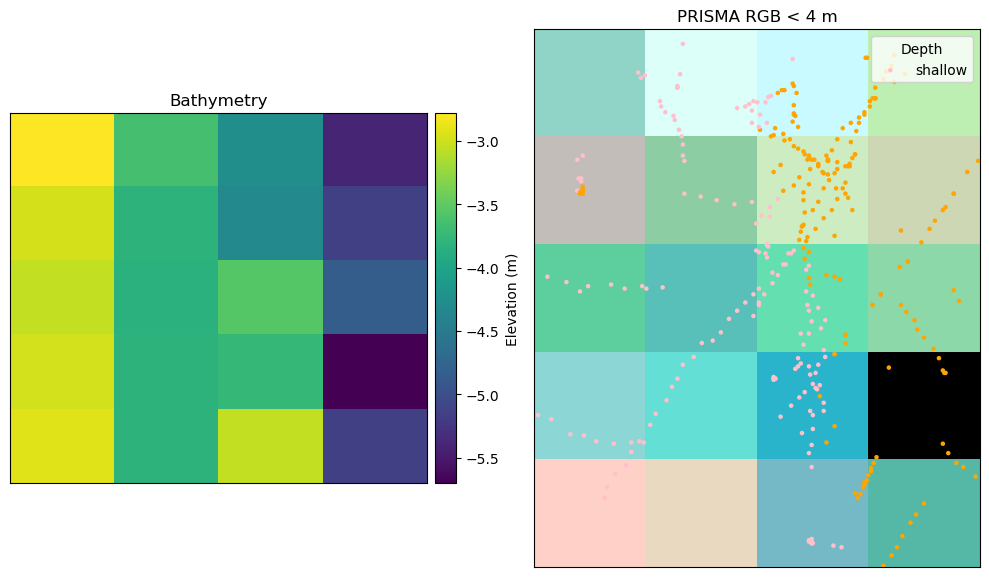

In [363]:

# Load the hyperspectral data 
with rio.open(img_file) as src:
    arr = src.read()
    transform = src.transform
    meta = src.meta
    
    # Open the reprojected bathymetry file in read mode and read the data into bathy_arr
    with rio.open(out_bathy_file) as reproj_bathy:
        bathy_arr = reproj_bathy.read(1)
        bathy_arr[bathy_arr==-3.4028234663852886e+38] = np.nan

        
        
        
        # Crop rasters to bounding box
        window = rio.windows.from_bounds(*gb_crop_bbox, transform=meta['transform'])
        window_transform = rio.windows.transform(window, src.transform)
        
        arr_crop = src.read(window=window)
        arr_crop[arr_crop == -999.0] = 0
        
        bathy_arr_crop = reproj_bathy.read(window=window)[0]
        bathy_arr_crop[bathy_arr_crop == -999.0] = np.nan
              
        
        # Filter sacfor points within the bounding box
        sacfor_bbox = sacfor[sacfor.within(box(*gb_crop_bbox))]
        
               
        # Mask the hyperspectral array with the bathymetry array where the values are greater than -4
        
        zmask = bathy_arr_crop < z_thresh
        
        arr_zmasked = np.ma.masked_array(arr_crop, mask=np.tile(zmask, (arr_crop.shape[0], 1, 1)))
        bathy_zmasked = np.ma.masked_array(bathy_arr_crop, mask=np.tile(zmask, (1, 1)))
        
        # Create a new column based on the elevations
        sacfor_bbox['depth criteria'] = np.where(sacfor_bbox['Elev(m)'] >= z_thresh, 'shallow', 'deep')
        # Add color criteria
        sacfor_bbox['color'] = np.where(sacfor_bbox['depth criteria'] == 'shallow', 'pink','orange')
        # sort out deep elevation
        sacfor_filt = sacfor[sacfor['Elev(m)']>=z_thresh]


                       
        # ----- set up gamma corrected rgb for plotting
        corr_rgb = arr_crop[[32, 18, 8], :, :]

        # Apply contrast stretching to improve the visibility
        stretched = np.zeros_like(corr_rgb)
        
        for i in range(3):
            stretched[i] = exposure.rescale_intensity(corr_rgb[i])

        # adjust brightness
        gamma_corrected = exposure.adjust_gamma(stretched, gamma=2)

        # plot the subset hyperspectral and bathymetry next to each other
        fig1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))
        
        show(bathy_arr_crop,transform = rio.windows.transform(window, src.transform), ax=ax1)
        ax1.set_title('Bathymetry')
        ax1.set_xticks([])
        ax1.set_yticks([])

        # colorbar for bathymetry
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad='2%')
        cbar = fig1.colorbar(im, cax=cax)
        cbar.set_label('Elevation (m)')

        # plot full rgb 
        show(gamma_corrected, transform = window_transform, ax=ax2)
        ax2.set_title('PRISMA RGB < 4 m')

        # add dropcamera locations shallow/deep

        depth = sacfor_bbox.plot(ax=ax2, 
                         column='depth criteria', 
                         markersize=5,
                         legend=True, 
                         color = sacfor_bbox['color'])
        ax2.legend(["shallow" , "deep"], ncol = 1 , loc = "upper right", title = 'Depth')
        ax2.set_xticks([])
        ax2.set_yticks([])
        
        fig1.tight_layout()
        plt.show()


        # save the cropped arr as a new raster (no depth masking)
        arr_crop_fout = 'prisma_gb_crop.tif'
        with rio.open(arr_crop_fout, 'w', driver='GTiff', width=arr_crop.shape[2], height=arr_crop.shape[1], count=arr_crop.shape[0], dtype=arr_crop.dtype, crs=src.crs, transform=window_transform) as dst:
            dst.write(arr_crop)

        # save cropped bathy arr as a new raster (no depth masking)
        bathy_crop_fout = 'bathy_reprojected_prisma_gb_crop.tif'
        with rio.open(bathy_crop_fout, 'w', driver='GTiff', width=bathy_arr_crop.shape[1], height=bathy_arr_crop.shape[0], count=1, dtype=bathy_arr_crop.dtype, crs=src.crs, transform=window_transform) as dst:
            dst.write(bathy_arr_crop,1)
        


    



/var/folders/69/6d1c0dr57w3c_dskwr2955mh0000gq/T/ipykernel_19264/2378098940.py:25: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  sacfor_bbox.plot(ax=ax1,
/var/folders/69/6d1c0dr57w3c_dskwr2955mh0000gq/T/ipykernel_19264/2378098940.py:31: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  sacfor_bbox.plot(ax=ax2,


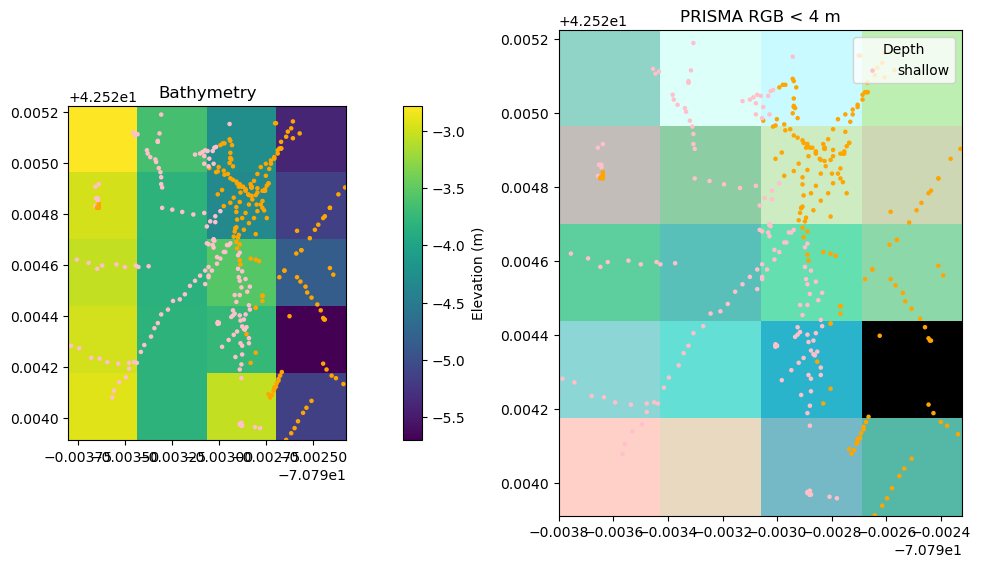

In [387]:
#test saved cropped tiffs
with rio.open(arr_crop_fout) as gb_src:
    gb_arr = gb_src.read()

    with rio.open(bathy_crop_fout) as gb_bathy_src:
        gb_bathy_arr = gb_bathy_src.read(1)

        # plot the subset hyperspectral and bathymetry next to each other
        fig1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))
        
        show(gb_bathy_arr,transform=gb_bathy_src.transform,ax=ax1)
        ax1.set_title('Bathymetry')

        # colorbar for bathymetry
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad='2%')
        cbar = fig1.colorbar(im, cax=cax)
        cbar.set_label('Elevation (m)')

        # plot full rgb 
        show(gamma_corrected, transform = gb_src.transform, ax=ax2)
        ax2.set_title('PRISMA RGB < 4 m')

        # add dropcamera locations shallow/deep
        sacfor_bbox.plot(ax=ax1, 
                         column='depth criteria', 
                         markersize=5,
                         legend=True, 
                         color = sacfor_bbox['color'])
        
        sacfor_bbox.plot(ax=ax2, 
                         column='depth criteria', 
                         markersize=5,
                         legend=True, 
                         color = sacfor_bbox['color'])
        ax2.legend(["shallow" , "deep"], ncol = 1 , loc = "upper right", title = 'Depth')
        
        fig1.tight_layout()
        plt.show()



### Create raster of mean SACFOR values within a PRISMA pixel

In [374]:
# input files
gb_img_file = 'prisma_gb_crop.tif'
gb_bathy_file = 'bathy_reprojected_prisma_gb_crop.tif'



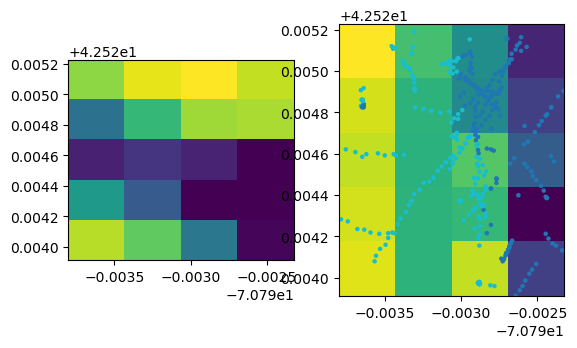

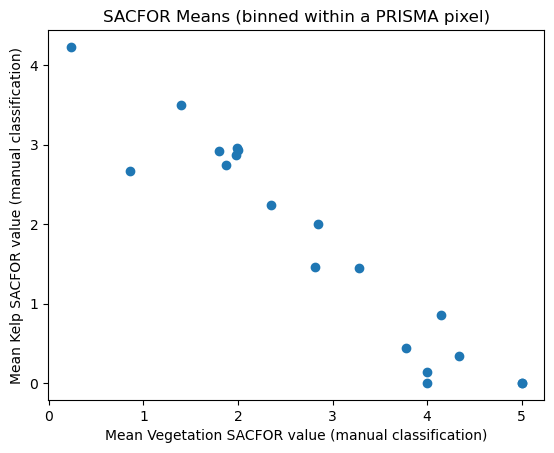

In [411]:


# Open the raster file
with rio.open(gb_img_file) as gb_src:
    gb_arr = gb_src.read()  # Read the first band (change the index if needed)
    gb_transform = gb_src.transform  # Get the geotransform information

    with rio.open(gb_bathy_file) as gb_bathy_src:
        gb_bathy_arr = gb_bathy_src.read(1)
        
    # pixel bounds dataframe 
    pix_bounds = pd.DataFrame(columns = ['row','col','minx', 'maxx', 'miny','maxy'])

    
    # Loop through each row and column in the raster
    for r,row in enumerate(range(0,gb_src.height)):
        for c,col in enumerate(range(0,gb_src.width)):
            # Get the spatial coordinates (x, y) of the pixel's top-left and bottom-right corners
            top_left = rio.transform.xy(gb_src.transform,row, col,offset='ul')
            bottom_right = rio.transform.xy(gb_src.transform,row, col,offset='lr')

            # populate the dataframe
            new_row = {'row': row,
                        'col': col,
                        'minx': top_left[0],
                        'maxx': bottom_right[0],
                        'miny': bottom_right[1],
                        'maxy': top_left[1]}
            
            pix_bounds.loc[len(pix_bounds)] = new_row
            
            #pix_bounds = pd.concat([pix_bounds,pd.DataFrame([new_row])],ignore_index=True)

    # create empty arrays for kelp and vegetation to  become rasters
    kelp_mean = np.zeros((gb_arr.shape[1],gb_arr.shape[2]), dtype=float)
    veg_corr_mean = np.zeros((gb_arr.shape[1],gb_arr.shape[2]), dtype=float)
    veg_all_mean = np.zeros((gb_arr.shape[1],gb_arr.shape[2]), dtype=float)

    # iterate through rows of pixel boundaries to find all the dropcam points in a pixel
    for index,row in pix_bounds.iterrows():
        
        pixel_bbox = [row.minx,row.miny,row.maxx,row.maxy]

        # plot to check bounds
        # plt.scatter(row.minx,row.maxy,alpha=0.5)
        # plt.scatter(row.maxx,row.miny,edgecolors='k',marker='^')

        # find all dropcamera sacfor points within a pixel
        sacfor_in = sacfor[sacfor.within(box(*pixel_bbox))]
        
        veg_corr = sacfor_in['veg #corr'].mean()
        veg_all = sacfor_in['veg #'].mean()
        kelp = sacfor_in['kel #'].mean()

        # # populate the dataframes/arrays with means
        # pix_bounds.loc[index].mean_kelp = kelp
        # pix_bounds.loc[index].mean_veg = veg

        kelp_mean[int(row.row),int(row.col)] = kelp
        veg_corr_mean[int(row.row),int(row.col)] = veg_corr
        veg_all_mean[int(row.row),int(row.col)] = veg_all
        
fig,(ax1,ax2) = plt.subplots(ncols=2)
show(gb_arr[50,:,:], transform = gb_src.transform,ax=ax1)
show(gb_bathy_arr,transform = gb_src.transform, ax=ax2)
sacfor_bbox.plot(ax=ax2, 
                 column='depth criteria', 
                 markersize=5)
plt.show()



plt.scatter(veg_corr_mean,kelp_mean)
plt.xlabel('Mean Vegetation SACFOR value (manual classification)')
plt.ylabel('Mean Kelp SACFOR value (manual classification)')
plt.title('SACFOR Means (binned within a PRISMA pixel)')
plt.show()

In [413]:
# output the new kelp and vegetation sacfor rasters to geotiffs
# outfile for new sacfor
kelp_out = 'kelp_sacfor_prisma_average.tif'
veg_out = 'veg_sacfor_prisma_average.tif'

with rio.open(kelp_out, 'w', driver='GTiff', width=kelp_mean.shape[1], height=kelp_mean.shape[0], count=1, dtype=kelp_mean.dtype, crs=src.crs, transform=gb_transform) as dst:
    dst.write(kelp_mean, 1)

with rio.open(veg_out, 'w', driver='GTiff', width=veg_corr_mean.shape[1], height=veg_corr_mean.shape[0], count=1, dtype=veg_corr_mean.dtype, crs=src.crs, transform=gb_transform) as dst:
    dst.write(veg_corr_mean, 1)


### Dimensionality Reduction - PCA on Headwall 

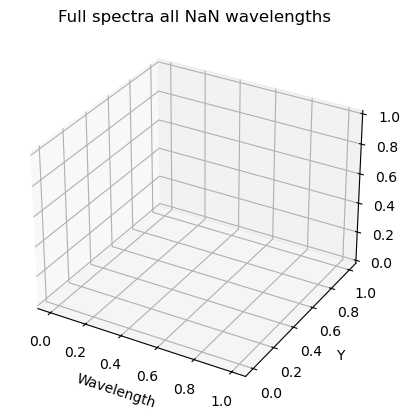

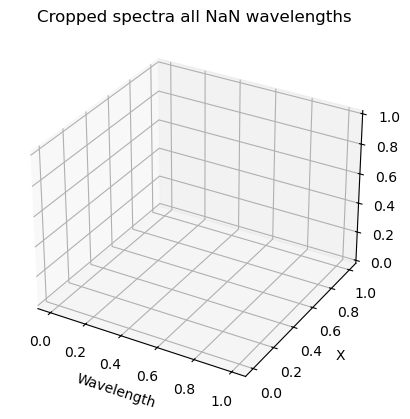

In [420]:
#### check for nans in hyperspectral data - cannot have for PCA
arr_test = arr_zmasked[:,:,:]

# create a boolean mask for NaN values
nan_mask = np.isnan(arr_zmasked)
nan_mask_test = np.isnan(arr_test)

# find the indices of NaN values
nan_indices = np.argwhere(nan_mask)
nan_indices_test = np.argwhere(nan_mask_test)

# visualize the NaN values using a scatter plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(nan_indices[:, 0], 
           nan_indices[:, 1], 
           nan_indices[:, 2], 
           c=nan_indices[:, 0])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Full spectra all NaN wavelengths')
plt.show()
                               
                              
fig1 = plt.figure()
ax = fig1.add_subplot(projection='3d')                               
ax.scatter(nan_indices_test[:, 0], 
           nan_indices_test[:, 1], 
           nan_indices_test[:, 2], 
           c=nan_indices_test[:, 0]) 
ax.set_xlabel('Wavelength')
ax.set_ylabel('X')
ax.set_zlabel('Y')
plt.title('Cropped spectra all NaN wavelengths')
plt.show()


In [422]:
# Crop the wavelengths of the image array to 450 - 728 nm
# removing NaNs for PCA
arr_clean = arr_test

# Convert to 2D numpy array
flattened_data = np.transpose(arr_clean, (1, 2, 0)).reshape(-1, arr_clean.shape[0])

# Perform PCA on the flattened data
pca = PCA(n_components = 10)
pca.fit(flattened_data)

# Transform the data into the PCA space
pca_data = pca.transform(flattened_data)

# Reshape the PCA data back into its original shape
pca_data = pca_data.reshape(arr_clean.shape[1], arr_clean.shape[2],-1)

#arr_clean_pca = arr_clean.reshape(arr_clean.shape[1], arr_clean.shape[2],arr_clean.shape[0])
arr_clean_pca = np.transpose(arr_clean, (1, 2, 0))

# # Save the PCA data to disk
# with rio.open(pca_file, 'w', **meta) as dst:
#     dst.write(pca_data)


### Pairing X and y data

In [137]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (sacfor_raster >= 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(sacfor_raster[sacfor_raster >= 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = arr_clean_pca[sacfor_raster >= 0,:]
#X_train = 
#X_test = 
#X = pca_data[sacfor_raster >= 0,:]
y = sacfor_raster[sacfor_raster >= 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 149 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (149, 123)
Our y array is sized: (149,)


In [138]:
# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [139]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 61.07382550335571%


In [141]:

bands = list(range(1, arr_clean_pca.shape[2]))

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

#

Band 1 importance: 0.018473883584634188
Band 2 importance: 0.014865489367374736
Band 3 importance: 0.010696081305595864
Band 4 importance: 0.010196017323803278
Band 5 importance: 0.009361363692008986
Band 6 importance: 0.010318971759606738
Band 7 importance: 0.006376897487044402
Band 8 importance: 0.006150822289754051
Band 9 importance: 0.008307888250940428
Band 10 importance: 0.00593428432604825
Band 11 importance: 0.0074300762085603685
Band 12 importance: 0.006583615472651252
Band 13 importance: 0.008185466789051306
Band 14 importance: 0.009419207282491574
Band 15 importance: 0.00666107039546999
Band 16 importance: 0.007928615065492885
Band 17 importance: 0.006921810692313417
Band 18 importance: 0.006838034150361133
Band 19 importance: 0.008243245299176211
Band 20 importance: 0.009593425642645845
Band 21 importance: 0.008081318227398084
Band 22 importance: 0.007451013875865292
Band 23 importance: 0.008320709798049804
Band 24 importance: 0.008973741041556297
Band 25 importance: 0.0096

In [142]:
# Setup a dataframe 
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict  1  2  3   4   5  All
truth                        
1        2  0  0   0   0    2
2        0  2  0   0   0    2
3        0  0  4   0   0    4
4        0  0  0  45   0   45
5        0  0  0   0  96   96
All      2  2  4  45  96  149


### Predicting the rest of the image

In [143]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
# use flattened_data var from above

# Now predict for each pixel
class_prediction = rf.predict(flattened_data)

# Reshape our classification map
class_prediction = class_prediction.reshape(arr_clean[0,:, :].shape)

# mask
class_prediction_mask = np.ma.masked_array(class_prediction, mask=np.tile(mask, (1, 1, 1)))

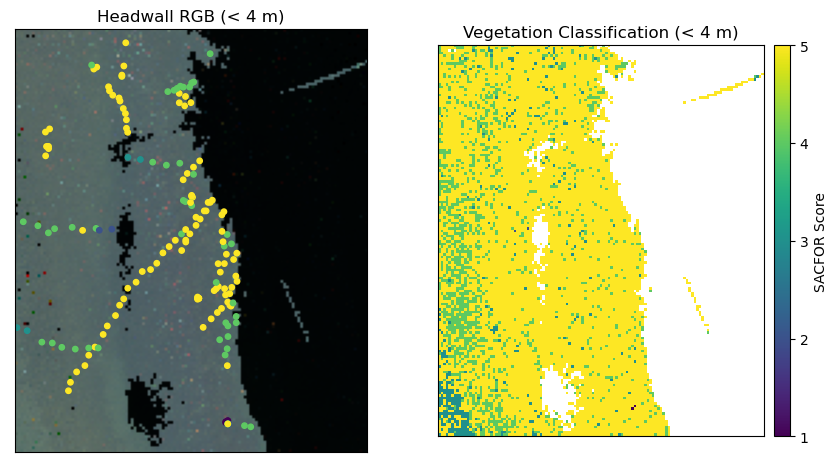

In [146]:
# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()

shallow = sacfor_bbox[sacfor_bbox['depth criteria'] == 'shallow']

# Now show the classmap next to the image
# set up gamma corrected rgb for plotting
# Red
# Green
# Blue - 
corr_rgb = arr_clean[[89, 44, 0], :, :]
gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)

# plot the hyperspectral and rasterized sacfor next to each other

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

show(gamma_corrected, 
     transform = rio.windows.transform(window, src.transform), ax=ax1)
ax1.set_title('Headwall RGB (< 4 m)')
shallow.plot(ax=ax1, 
             c=shallow['veg #'], 
             markersize=15)
ax1.set_xticks([])
ax1.set_yticks([])

im = ax2.imshow(class_prediction_mask, 
           cmap='viridis', 
           interpolation='none')
ax2.set_title('Vegetation Classification (< 4 m)')
ax2.set_xticks([])
ax2.set_yticks([])
# resize the colorbar to match the size of ax2
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax, cmap='viridis')
#cbar.set_ticks(np.arange(n+1))
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks([1, 2, 3, 4, 5])
cbar.set_label('SACFOR Score')
plt.show()

### Output classification as a raster

In [403]:
# Load the hyperspectral data 
with rio.open(img_file) as src:
    arr = src.read()
    meta = src.meta
    
    # Create a new output file using the metadata of the input file
    output_profile = src.profile
    output_profile.update(dtype=rasterio.uint8, 
                          count=1,
                          nodata=255,
                         width=corr_rgb.shape[2],
                         height=corr_rgb.shape[1])

    # Write the masked array to the output file
    with rio.open("GB_normR_kelp_prediction.tif", "w", **output_profile) as dst:
        dst.write(class_prediction_mask.filled(fill_value=255), 1)
    
    # output masked RGB
    output_profile.update(count=3) # update count to 3 for 3 bands
    with rio.open("GB_normR_rgb.tif", "w", **output_profile) as dst:
        dst.write(corr_rgb.filled(fill_value=255))

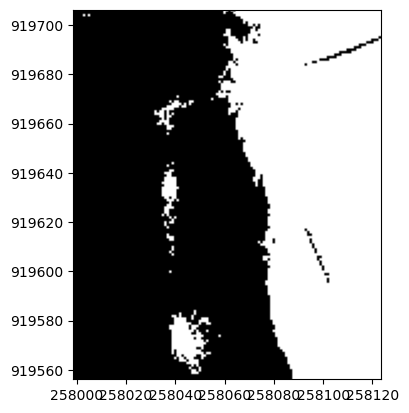

In [331]:
#open cropped rgb

with rio.open('GB_normR_rgb.tif') as src:
    arr = src.read()
    meta = src.meta
    
    show(arr,transform=src.transform)
